## MA755 - Assigment 1 - Predict The average annual total cost of attendance 

by Ignacio Carracedo and


## SUMMARY

This notebook explores builts a model that predicts the average annual total cost of attendance to an education intitution.
The idea is that the cost can be predited using the some features of the institution itself like the demography, location, dreegrres that are offered, size, etc.

The goal is not only to predict but also to find out what features have more influence in the price.


Before we start let's show the the specifications of our server and version of the libraries we are working with. Then we will import all the libraries that we will use on this notebook

In [5]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-02-10 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [12]:
# IMPORTS
import os
from os import listdir
from os.path import isfile, join
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

# CONTANTS
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

The college data set can be downloaded from 'https://collegescorecard.ed.gov/data/'. Data is compress in a zip file that has a .csv file per school year. The following funtion will:

* Download dataset
* Extract zip file

In [2]:
def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()

In [ ]:
fetch_housing_data()

The files is now downloaded into __datasets\collegescorecard\CollegeScorecard_Raw_Data__ folder. As we said, thre is one file per year so we need to read each of the .csv files and concatenate them to end up with just one file. The following function will do this and return one final data frame with all the years. The function takes a string as an argument and will only download files that have the string in the name.

Note how a new column YEAR is added to the data frame so we know from which year is each observation (row)

In [3]:
def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "" ):
    college_list = []
    #get list of files in directory that are .csv and starting 2000 (memory issues)
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f))) and (".csv" in f) and ("201" in f)]
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")    
    return pd.concat(college_list)

Due to the size of the dataset we are only going to use files from this decade (pass strint '201' as an argument)

In [6]:
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...
Concatenating files ...


Now we have one files with all the data. We save the dataframe so we don't have to download the data and concatenate it again. 

In [7]:
college.to_csv(COLLEGE_PATH+'/college.csv',index=False) #save
#college = pd.read_csv(COLLEGE_PATH+'/college.csv', encoding = "ISO-8859-1")

Let's check how big is our dataframe and inpect the first 5 lines

In [8]:
print(college.shape)
college.head()

(38389, 1744)


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


On this notebook we are only going to focus on the last year to facilitate data cleaning and avoid duplicates. The above functions will be useful for any other projects. Let's filter our dataset and get only rows of the year 2014. We will also save this new dataframe.

In [10]:
college2014 = college[college['YEAR']==2014]
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False) # 
del college # to save memory

Now that the 'college2014' is saved we can start from this next cell next time we run the notebook, we just need to load the cvs file

In [21]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1",low_memory=False)

We want to select variables that doen't have many missing values as we are going to feed these into our machine learning model. Let's built a funtion that will select what columns to keep depending on how many missing values there are.

Let's keep in mind that we are looking for features that define the instituion.

In [7]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_rows = college2014.shape[0]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("Keeping %s out of %s columns." %(len(columns), total_rows))
    return (df)

As we said we want to predict COSTT4_A so lets drop the rows where COSTT4_A is not null

In [8]:
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)
college2014.shape

(4030, 1744)

We end up with 4030 rows which are not many for a machine learning model. 

Now we can check which columns have few values and keep some of those we think interesting, we'll set the theashold of missing values to 10%

In [9]:
for i in (np.sort(cols_few_missing_values(college2014,0.1).columns)):
    print(i)

Keeping 468 out of 4030 columns.
?UNITID
AANAPII
ACCREDAGENCY
AGE_ENTRY
ANNHI
APPL_SCH_N
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
AVGFACSAL
CCBASIC
CCSIZSET
CCUGPROF
CDR3
CDR3_DENOM
CIP01ASSOC
CIP01BACHL
CIP01CERT1
CIP01CERT2
CIP01CERT4
CIP03ASSOC
CIP03BACHL
CIP03CERT1
CIP03CERT2
CIP03CERT4
CIP04ASSOC
CIP04BACHL
CIP04CERT1
CIP04CERT2
CIP04CERT4
CIP05ASSOC
CIP05BACHL
CIP05CERT1
CIP05CERT2
CIP05CERT4
CIP09ASSOC
CIP09BACHL
CIP09CERT1
CIP09CERT2
CIP09CERT4
CIP10ASSOC
CIP10BACHL
CIP10CERT1
CIP10CERT2
CIP10CERT4
CIP11ASSOC
CIP11BACHL
CIP11CERT1
CIP11CERT2
CIP11CERT4
CIP12ASSOC
CIP12BACHL
CIP12CERT1
CIP12CERT2
CIP12CERT4
CIP13ASSOC
CIP13BACHL
CIP13CERT1
CIP13CERT2
CIP13CERT4
CIP14ASSOC
CIP14BACHL
CIP14CERT1
CIP14CERT2
CIP14CERT4
CIP15ASSOC
CIP15BACHL
CIP15CERT1
CIP15CERT2
CIP15CERT4
CIP16ASSOC
CIP16BACHL
CIP16CERT1
CIP16CERT2
CIP16CERT4
CIP19ASSOC
CIP19BACHL
CIP19CERT1
CIP19CERT2
CIP19CERT4
CIP22ASSOC
CIP22BACHL
CIP22CERT1
CIP22CERT2
CIP22CERT4
CIP23ASSOC
CIP23BACHL

As we can see there are many columns that have 10% or less missing values. We could keep adjusting the threashold if needed.

After reviewing many features we ended up selecting feaures that we thought could be indicative of the averagre price of the institution. The goal is not only to predict but also to find out what features have more influence in the price.

We select:

* CONTROL:  Public, Private nonprofit, Private for-profit
* DEBT_N: The number of students in the median debt cohort
* IND_DEBT_MDN: The median debt for independent students
* MAIN: Flag for main campus
* ST_FIPS: FIPS code for state
* ICLEVEL: institutional_characteristics.level 4-year,2-year,Less-than-2-year
* NUMBRANCH: Number of branch campuses
* PREDDEG: "Predominant undergraduate degree awarded 0 Not classified 1 Predominantly certificate-degree granting 2  Predominantlyassociate's-degree granting 3 Predominantly bachelor's-degree granting 4 Entirely graduate-degree granting"
* HIGHDEG: "Highest degree awarded 0 Non-degree-granting 1 Certificate degree 2 Associate degree 3 Bachelor's degree 4 Graduate degree"
* PBI: Flag for predominantly black institution
* PAR_ED_PCT_1STGEN: Percentage first-generation students
* MENONLY
* WOMENONLY
* PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09", "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22", "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38", "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47", "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54" : types of degrees offered.
* UGDS_2MOR
* UGDS_AIAN
* UGDS_ASIAN
* UGDS_BLACK
* UGDS_HISP
* UGDS_MEN
* UGDS_NHPI
* UGDS_NRA
* UGDS_UNKN
* UGDS_WHITE
* UGDS_WOMEN
* UG: Enrollment of all undergraduate students
* UGDS: Enrollment of undergraduate certificate/degree-seeking students

Let's select these features:

In [22]:
columns = ['COSTT4_A','CONTROL', 'MAIN', 'ST_FIPS', 'ICLEVEL', 'NUMBRANCH','PREDDEG','HIGHDEG',
           'MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09",
           "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22",
           "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38",
           "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
           "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE",
           "UGDS_WOMEN", "UGDS"]

college2014 = college2014[columns]

Next, we split the dataset in a traning set that we will use to train our model (CV will be used to tune it staying within the training set) and a test set. We won't use the test set becuse we don't want to be bias when testing the final model. We need some fresh data that hasn't been used before.

When stratify split using the states. The reason being is that some states don't have many values and we want to have the same representation on both the training set and the test set. Also notice how some states have only one value which won't work if we split the data. One possible solution is to join the less represented states into one gruop that we will call others. All these states are mostly island as we can see below:

In [25]:
college2014.ST_FIPS.value_counts().sort_values().head(10)

70.0     1
60.0     1
69.0     1
68.0     1
64.0     1
78.0     2
66.0     3
2.0     10
56.0    11
10.0    19
Name: ST_FIPS, dtype: int64

We will them join 60,64,66,68,69,70,72,78

* 60	American Samoa
* 64	Federated States of Micronesia
* 66	Guam
* 69	Northern Mariana Islands
* 70	Palau
* 72	Puerto Rico
* 78	Virgin Islands

Let's proceed with the split

In [13]:
def split(X):
    '''this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state'''

    #islands to same number for stratified split
    X["ST_FIPS"] = X["ST_FIPS"].map(lambda x: 100 if x in [60,64,66,68,69,70,72,78] else x)
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["ST_FIPS"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

Now we can check the historgram for each numeric feature. Most of our features are categorical and are encoded using an integer so the historgrams are not really helpful but it gives us a general idea of the data we are working with:

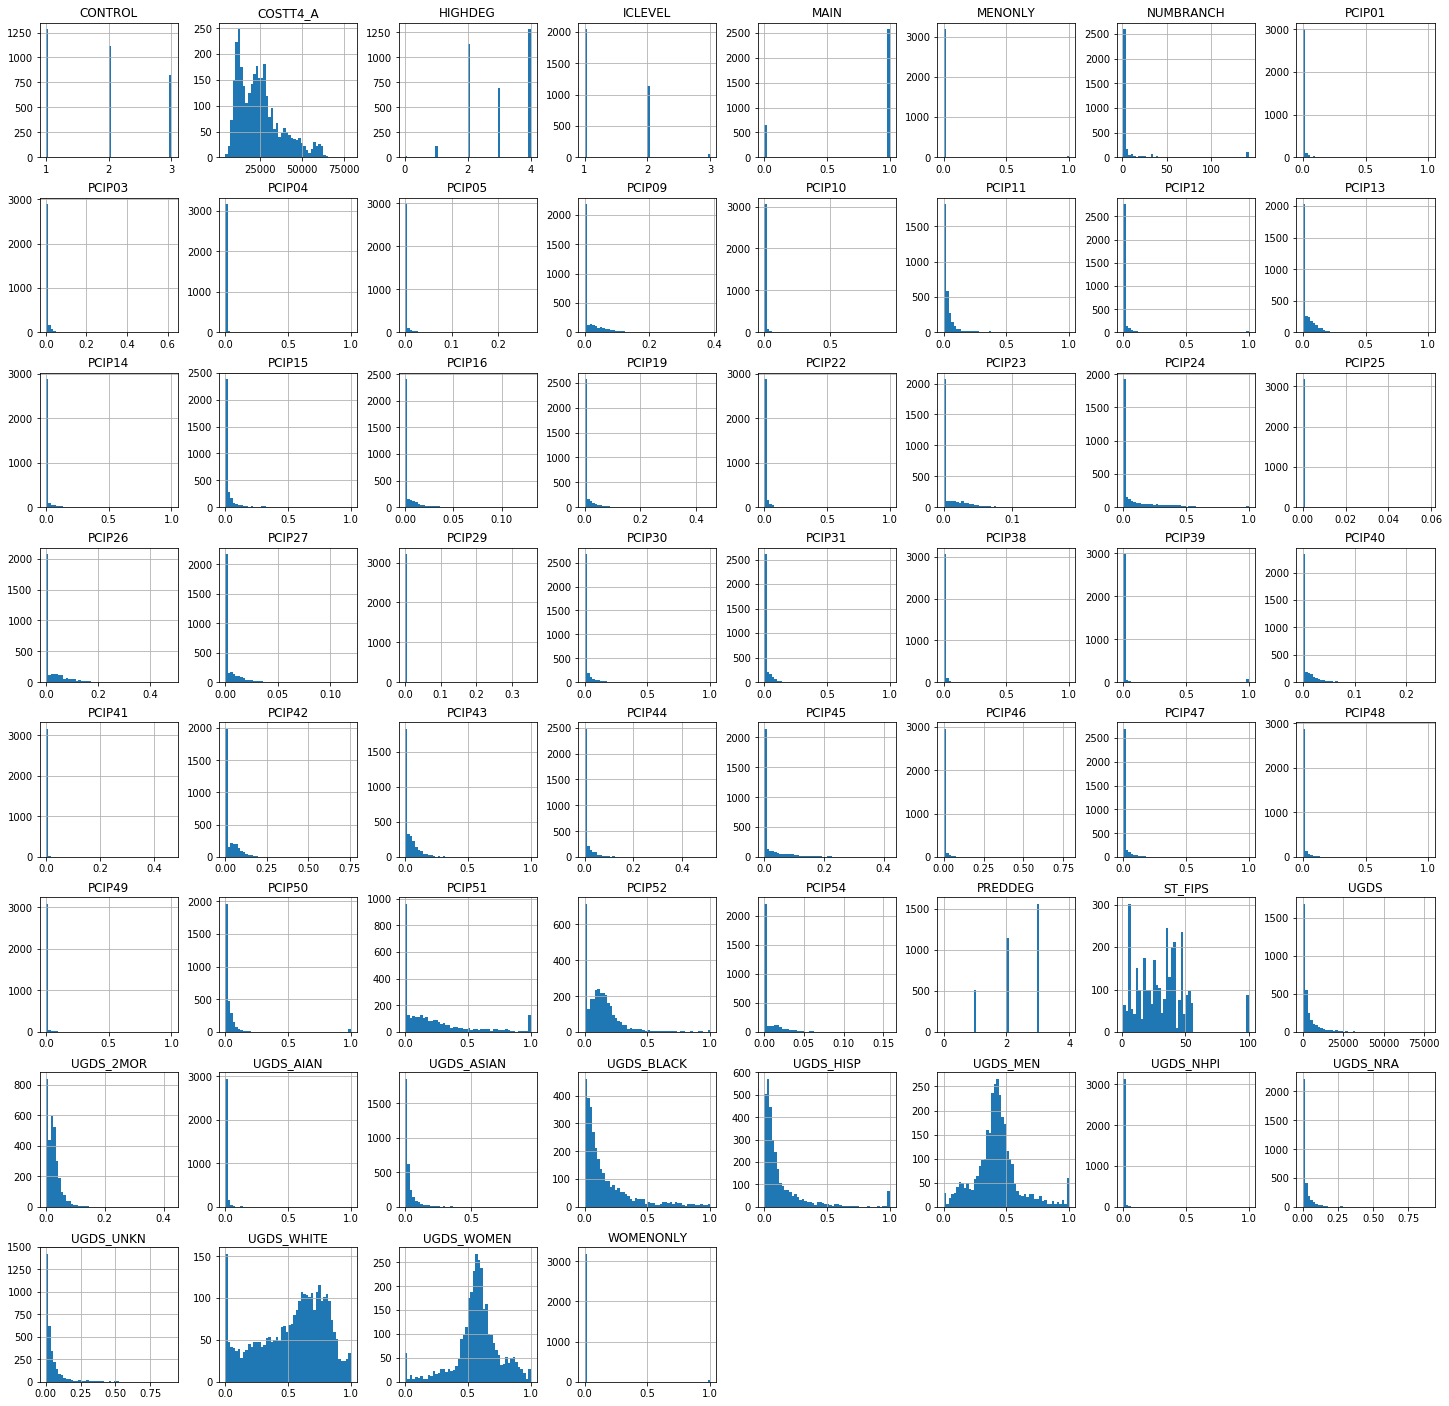

In [14]:
train_set.hist(bins=50, figsize=(25,25))
plt.show()

Let's see how the the target variable histogram looks like

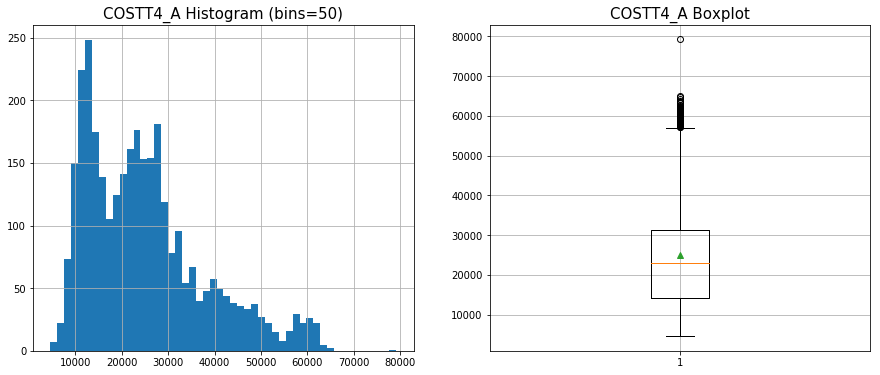

In [65]:
fig = plt.figure(figsize=(15,6))

#hist
ax1 = fig.add_subplot(121)
ax1.hist(train_set.COSTT4_A,bins=50)
ax1.grid(True)
plt.title("COSTT4_A Histogram (bins=50)", size=15)

#boxplot
ax2 = fig.add_subplot(122)
ax2.boxplot(train_set.COSTT4_A, showmeans=True)
ax2.grid(True)
plt.title("COSTT4_A Boxplot",  size=15)
plt.show()

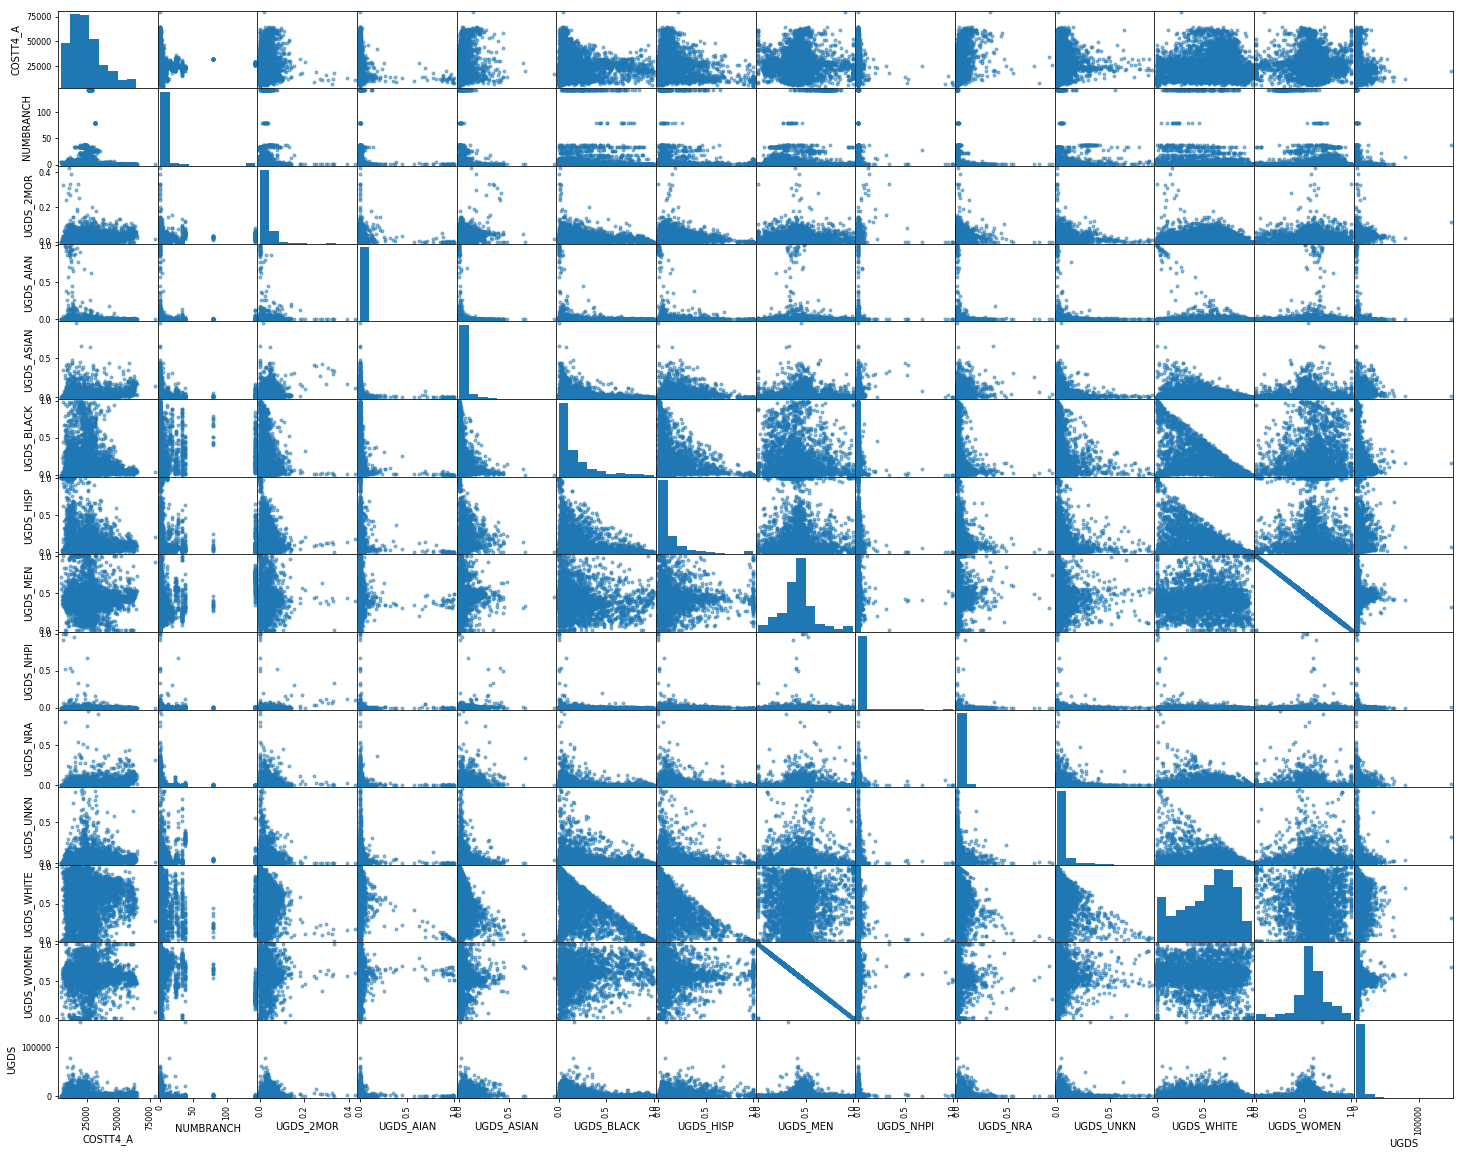

In [10]:
from pandas.tools.plotting import scatter_matrix

attributes = ["COSTT4_A", "NUMBRANCH","UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
              "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA",
              "UGDS_UNKN", "UGDS_WHITE", "UGDS_WOMEN","UGDS"]

scatter_matrix(train_set[attributes], figsize=(25, 20))
plt.show()

Not much correlation but at least we can see we don't need both UGDS woman and man. They look complementary, let's double check

In [15]:
train_set[["UGDS_MEN","UGDS_WOMEN"]].head()

,UGDS_MEN,UGDS_WOMEN
4647,0.3415,0.6585
6579,0.0000,1.0000
1755,0.6021,0.3979
5591,0.0857,0.9143
1674,0.9029,0.0971


Lets check how many missing values we have (many different ways of doing it):

In [34]:
train_set.drop("UGDS_WOMEN", 1, inplace=True)

let's check correlation

In [19]:
corr_matrix = train_set.corr()
corr_matrix["COSTT4_A"].sort_values(ascending=False)[:20]

COSTT4_A      1.000000
HIGHDEG       0.482828
PREDDEG       0.457039
PCIP23        0.441742
PCIP26        0.439033
PCIP45        0.429653
CONTROL       0.415113
PCIP54        0.414856
PCIP27        0.391832
PCIP40        0.340300
PCIP16        0.335022
UGDS_NRA      0.324657
PCIP09        0.287758
PCIP42        0.282003
PCIP50        0.259551
PCIP05        0.188675
PCIP14        0.163201
WOMENONLY     0.155984
UGDS_ASIAN    0.147166
UGDS_UNKN     0.117831
Name: COSTT4_A, dtype: float64

Let check missing values

In [106]:
print("Number of featues with at least 1 missing value: %s"
      %(train_set.isnull().sum() != 0).sum())

Number of featues with at least 1 missing value: 0


We don't have missing values!!!!!!!!!!!! nice!

We now know all the neccesary steps we need to take to get the data ready for a machine learning models. To simplify building models we are going to create a pipeline that will get the original data and will output the data we'll feed to our models.

For the pipeline to work we need to create custom tranfomres. These classes will have the same structuture as skilearn tranformers, that means all will have the funtions fit, tranform, and fit_tranform (this one will be inherit from TransformerMixin). BaseEstimator will provide the implementation of get_params and set_params(\*\*params).

We'll define to custom tranformers:

* one_hot:
* transform:

and one function:

* split:

### Custom transformers

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class one_hot(BaseEstimator, TransformerMixin):
    
    def __init__(self): 
        self.control_encoder = OneHotEncoder(sparse=False)
        self.iclever_encoder = OneHotEncoder(sparse=False)
        self.st_encoder = OneHotEncoder(sparse=False)
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X.reset_index(drop=True,inplace=True)
                
        CONTROL = self.control_encoder.fit_transform(X["CONTROL"].reshape(-1, 1))
        control_df = pd.DataFrame(CONTROL, columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
        X = pd.concat([X, control_df], axis=1)
        X.drop("CONTROL",axis=1,inplace=True)
                
        ICLEVEL = self.iclever_encoder.fit_transform(X["ICLEVEL"].reshape(-1, 1))
        iclevel_df = pd.DataFrame(ICLEVEL, columns=["ICLEVEL1","ICLEVEL2","ICLEVEL3"]).reset_index(drop=True)
        X = pd.concat([X, iclevel_df], axis=1)
        X.drop("ICLEVEL",axis=1,inplace=True)
        
        ST_FIPS = self.st_encoder.fit_transform(X["ST_FIPS"].reshape(-1, 1))
        st_fips_df = pd.DataFrame(ST_FIPS).reset_index(drop=True)
        X = pd.concat([X, st_fips_df], axis=1)
        X.drop("ST_FIPS",axis=1,inplace=True)

        return X

    
class feature_selection(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        return X[self.attribute_names]

    
def split(X):
    '''this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state'''

    #islands to same number for stratified split
    X["ST_FIPS"] = X["ST_FIPS"].map(lambda x: 100 if x in [60,64,66,68,69,70,72,78] else x)
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["ST_FIPS"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

## PIPELINE

Now that we have define our tranformers we can run our pipeline to get the proccess data. The pipeline will use the fit_transform method of each tranformer and pass the output to the next step of the pipeline. Once that is done we can apply the split funtion to get our train and test set. 

In [14]:
# load data
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1",low_memory=False)
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)

#columns to keep
columns = ['COSTT4_A','CONTROL', 'MAIN', 'ST_FIPS', 'ICLEVEL', 'NUMBRANCH','PREDDEG','HIGHDEG',
           'MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09",
           "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22",
           "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38",
           "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
           "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE", "UGDS"]

#pipeline
college_pipeline = Pipeline([
        ('feature_selection', feature_selection(columns)),
        ('one_hot', one_hot()),
        #('std_scaler', StandardScaler()),
    ])

# run pipeline
train_set, test_set = split(college2014)
train_set = college_pipeline.fit_transform(train_set)
test_set = college_pipeline.fit_transform(test_set)

# check sets size
print("The size of the train set is: %s " %train_set.shape[0])
print("The size of the test set is: %s " %test_set.shape[0])

The size of the train set is: 3224 
The size of the test set is: 806 


## MODEL

In [68]:
X_train = train_set.drop("COSTT4_A", axis=1)
y_train = train_set["COSTT4_A"]
X_test = test_set.drop("COSTT4_A", axis=1)
y_test = test_set["COSTT4_A"]

In [69]:
y_train.describe()

count     3224.000000
mean     24964.737903
std      12843.622224
min       4610.000000
25%      14158.750000
50%      22938.500000
75%      31318.750000
max      79212.000000
Name: COSTT4_A, dtype: float64

Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (ie. a negative
value), which is why the code above computes -scores before
calculating the square root.

## SELECT MODEL

In [6]:
tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 6551.97866966  8225.23197804  7591.06373831  7030.75710849  6427.67778551
  6236.01524008  6433.16688625  7197.81736241  5668.20704998  5965.22375292
  6379.37842286  6771.13044499  9123.8934532   5998.10612502  6883.06868856
  5565.28904899  6734.13771772  5399.97625254  7029.75281896  6170.65870327]
Mean: 6669.12656239
Standard deviation: 875.287154065


In [7]:
lin_reg = LinearRegression()

tree_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 5900.61690729  5854.78464966  5489.64322131  7082.20382833  5817.18058331
  6543.11087228  5516.21198736  6165.78877282  5034.59968284  5554.0572892
  6342.90376348  4688.51324601  7378.02750607  5114.70055952  5375.58528873
  5250.312866    6012.96997724  5798.99578305  5998.84207188  6018.31873594]
Mean: 5846.86837962
Standard deviation: 641.386286059


In [9]:
forest_reg = RandomForestRegressor()

tree_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 4750.81816394  5943.55283376  5462.24083965  6470.47588691  4989.41930688
  5309.53504578  4736.30713271  5784.14377669  4616.86481518  4915.02533504
  4870.88886486  4258.04672435  5510.7283065   4344.82955426  4902.70285035
  4984.89625773  4863.89879909  4788.17561073  4242.41892366  4407.29039722]
Mean: 5007.61297126
Standard deviation: 570.838009455


## TUNE MODEL

In [71]:
param_grid = [{'n_estimators': [750, 1000], 'max_features': ["auto", "sqrt", 40],
               'bootstrap': [True, False], 'min_samples_leaf':[1,5,10,25]}]



forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_leaf': [1], 'bootstrap': [True], 'n_estimators': [1000], 'max_features': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

 ----------------- GRID_SEARCH INFO -----------------
 
{'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'max_features': 'auto'}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Best CV score: 4812.99126027
4812.99126027 {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'max_features': 'auto'}

 ----------------- FEATURE IMPORTANCE INFO ----------------- 
(0.40891384677200288, 'CONTROL')
(0.10290344409564284, 'PCIP23')
(0.055492614663670253, 'PCIP40')
(0.05077711575655891, 'UGDS_NRA')
(0.045521929211992426, 'UGDS_ASIAN')
(0.032362747526270448, 'PCIP45')
(0.030646727467567809, 'PREDDEG')
(0.029123672461146024, 'PCIP27')
(0.026196463344641274, 'UGDS_HIS

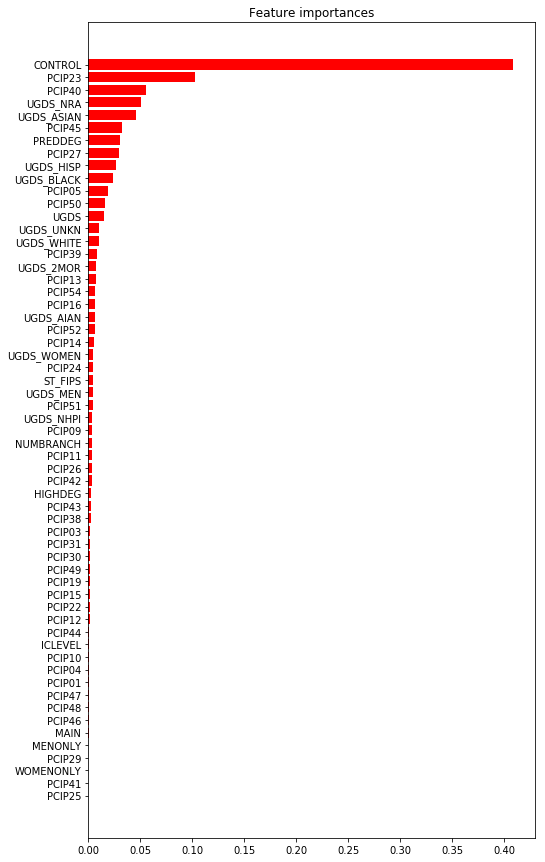

In [142]:
print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("Best CV score:", np.sqrt(-grid_search.best_score_))

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

print("\n ----------------- FEATURE IMPORTANCE INFO ----------------- ")    
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns

# print feature_importances
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)
for f in fimpotances:
    print(f)

# plot 15 most important features 
plt.figure(figsize=(8, 15))
plt.barh(range(X_train.shape[1]), feature_importances[indices], color="r", align="center")
plt.yticks(range(X_train.shape[1]), t)
plt.title("Feature importances")
plt.gca().invert_yaxis()
plt.show()


## FINAL MODEL

In [73]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 4467.39
final_rmse

4599.295262899841

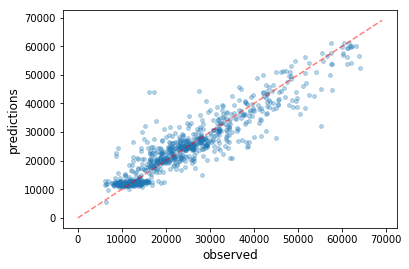

In [103]:
plt.scatter(y_test,final_predictions,alpha=0.3, s=15)
plt.xlabel('observed', fontsize=12)
plt.ylabel('predictions', fontsize=12)
plt.plot([0,(np.max(y_test) + 5000)],[0,(np.max(y_test) + 5000)], 'r--', alpha=0.5)
plt.show()

TODO:
    
* Regression to interpret each coefficient
* Check other features
* Scale and other data tranformation
* Try to get more data

The end